<a href="https://colab.research.google.com/github/LuigiElo/DL-PINNs/blob/main/Nice_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip install git+https://github.com/dr-aheydari/SoftAdapt.git

  Cloning https://github.com/dr-aheydari/SoftAdapt.git to /tmp/pip-req-build-970mbc5v
  Running command git clone --filter=blob:none --quiet https://github.com/dr-aheydari/SoftAdapt.git /tmp/pip-req-build-970mbc5v
  Resolved https://github.com/dr-aheydari/SoftAdapt.git to commit 5fc955f424052cc94824d7ba9d7e7ea564c8e254
  Preparing metadata (setup.py) ... done


In [34]:
from softadapt import SoftAdapt, NormalizedSoftAdapt, LossWeightedSoftAdapt

#Network

In [69]:
import torch
import torch.nn as nn

class SineActivation(nn.Module):
    def forward(self, x):
        return torch.sin(x)

class FNN(nn.Module):
    def __init__(
        self,
        num_inputs: int = 2,
        num_layers: int = 4,
        num_neurons = [256,128,64,32],
        dropout_rate: float = 0.5,  # Add dropout rate as a parameter
        act: nn.Module = SineActivation(),
    ) -> None:
        """Basic neural network architecture with linear layers

        Args:
            num_inputs (int, optional): the dimensionality of the input tensor
            num_layers (int, optional): the number of hidden layers
            num_neurons (int, optional): the number of neurons for each hidden layer
            act (nn.Module, optional): the non-linear activation function to use for stitching
                linear layers togeter
        """
        super().__init__()

        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers

        layers = []

        # input layer
        layers.append(nn.Linear(self.num_inputs, num_neurons[0]))

        # hidden layers with linear layer and activation
        for i in range(num_layers):
            layers.extend([nn.Linear(num_neurons[i], num_neurons[i] if i is len(num_neurons)-1 else num_neurons[i+1]),act])
            # Add dropout after every other linear layer
            #if i % 2 == 1:
            #  layers.extend([nn.Linear(num_neurons, num_neurons),act])
            #else:
            #  layers.extend([nn.Linear(num_neurons, num_neurons), nn.Dropout(dropout_rate) ,act])


        # output layer
        layers.append(nn.Linear(num_neurons[-1], 1))

        # build the network
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

#network

# Example usage:
"""
model = LinearNN()
input_tensor = torch.randn((10, 2))  # Example input with batch size 10 and 2 features
output = model(input_tensor)

print("Input shape:", input_tensor)
print("Output shape:", output)"""

'\nmodel = LinearNN()\ninput_tensor = torch.randn((10, 2))  # Example input with batch size 10 and 2 features\noutput = model(input_tensor)\n\nprint("Input shape:", input_tensor)\nprint("Output shape:", output)'

#PINN Loss

In [70]:
import torch.nn.functional as F
import torch.autograd.functional as autograd

def data_loss(predicted_data, target_data): #data has to be in z=0, 0<x<L
        #target data is obtained using behaviour function
        #return F.mse_loss(predicted_data, target_data)
        #criterion=torch.nn.L1Loss()
        criterion=torch.nn.SmoothL1Loss()
        #target_data = target_data.view(-1, 1)  # Assuming you want a column vector
        predicted_data =predicted_data.view(-1,1)
        #print("TARGET: ",target_data.shape)
        #print("PREDICTED :",predicted_data.shape)
        return criterion(predicted_data, target_data)

def boundary_condition_loss(boundary_conditions,output):
    # Customize based on your specific boundary conditions
    # Example: Dirichlet boundary condition u(0, t) = g(t)
    #loss_bc = F.mse_loss(boundary_conditions['bc1'], torch.zeros_like(output)) + F.mse_loss(boundary_conditions['bc2_0'], boundary_conditions['bc2_1'])
    # instead of 0 it will be an array of zeros with the same length as the number of points we decide to use to calculate the loss
    #criterion=torch.nn.L1Loss()
    criterion=torch.nn.SmoothL1Loss()
    loss_bc = criterion(boundary_conditions['bc1'], torch.zeros_like(output)) + criterion(boundary_conditions['bc2_0'], boundary_conditions['bc2_1'])
    return loss_bc

def periodic_boundary_loss(boundary_conditions):
    # Customize based on your specific boundary conditions
    # Example: Dirichlet boundary condition u(0, t) = g(t)
    #loss_bc = F.mse_loss(boundary_conditions['bc1'], torch.zeros_like(output)) + F.mse_loss(boundary_conditions['bc2_0'], boundary_conditions['bc2_1'])
    # instead of 0 it will be an array of zeros with the same length as the number of points we decide to use to calculate the loss
    #criterion=torch.nn.L1Loss()
    criterion=torch.nn.SmoothL1Loss()
    loss_bc = criterion(boundary_conditions['bc2_0'], boundary_conditions['bc2_1'])
    return loss_bc

def bottom_velocity_boundary_loss(boundary_conditions,output):

    #criterion=torch.nn.L1Loss()
    criterion=torch.nn.SmoothL1Loss()
    loss_bc = criterion(boundary_conditions['bc1'], torch.zeros_like(output))
    return loss_bc

def pde_loss(model,input_data): #here input_data has to be in -h(x)<x2<0
#
#    # Forward pass to get the function values
#    output = model(input_data)
#    pde_residuals=[]
#    for o,d in zip(output,input_data):
      # Compute the Hessian matrix
#      hessian = compute_hessian(o, d)

      # Extract elements corresponding to (0, 0) and (1, 1)
      #hessian_00 = hessian[0, 0]
      #hessian_11 = hessian[1, 1]

      #pde_residuals.append(hessian_00+hessian_11)
    pde_residuals_tensor = compute_hessian(model,input_data)
    #print(f"{hessians.sum(dim=1)}")
    #pde_residuals_tensor = hessians.sum(dim=1)
    #pde_residuals_tensor = torch.cat([residual.unsqueeze(0) for residual in pde_residuals])

    # Use torch.zeros_like with the tensor
    #return F.mse_loss(pde_residuals_tensor, torch.zeros_like(pde_residuals_tensor))
    #criterion=torch.nn.L1Loss()
    criterion=torch.nn.SmoothL1Loss()
    return criterion(pde_residuals_tensor, torch.zeros_like(pde_residuals_tensor))

def compute_bc1(model,  x1,x2):

    x1_tensor = torch.tensor(x1, dtype=torch.float32, requires_grad=True)
    x2_tensor = torch.tensor(x2, dtype=torch.float32 , requires_grad=True)

    # Concatenate x1 and x2 to form the input tensor
    input_tensor = torch.stack([x1_tensor, x2_tensor], dim=1)

    # Forward pass through the model
    output = model(input_tensor)

    # Compute the gradient with respect to x2
    grad_x2 = torch.autograd.grad(output, input_tensor,grad_outputs=torch.ones_like(output), create_graph=True)[0][:, 1]

    # Initialize a list to store the gradients for each element of x2_tensor
    #gradients_x2 = []

    # Compute the gradient for each element of output with respect to x2_tensor
    #for i in range(len(output)):
    #    grad_x2_element = torch.autograd.grad(output[i], x2_tensor[i], create_graph=True)[0]
    #    gradients_x2.append(grad_x2_element)

    # Stack the gradients into a tensor
    #grad_x2 = torch.stack(gradients_x2, dim=0)

    #print(f'Gradient bottom: {grad_x2}')
    return grad_x2

def compute_bc2(model, input_tensor):

    # Forward pass through the model
    output = model(input_tensor)

    #print(f'output: {output}')
    return output

#def compute_hessian(output, input_data):
#    hessian = autograd.hessian(lambda x: output, input_data)
#    return hessian

def compute_hessian(model, input_data):
    output = model(input_data)
    # Calculate the first-order gradients
    gradients = torch.autograd.grad(output, input_data, grad_outputs=torch.ones_like(output), create_graph=True)[0]

    # Calculate the second-order gradients for each element of input_data
    hessian = torch.zeros_like(input_data)
    for i in range(input_data.shape[1]):
      hessian[:, i] = torch.autograd.grad(gradients[:, i], input_data, grad_outputs=torch.ones_like(gradients[:, i]), create_graph=True)[0][:, i]

    return hessian.sum(dim=1)
#x1 and x2 have to represent the points we want to apply the constraints

#boundary_conditions = {
#    'bc1': compute_bc1(model, x1, -1),   # at x2=-1 the grad perpendicular to the bottom is null
#    'bc2_0': compute_bc2(model, 0, x2),  # at x1 = 0
#    'bc2_1': compute_bc2(model, 2, x2),  # at x1 = 2
#}

#total_loss = loss_data + loss_bc + loss_pde

#the data we provide to calculate each loss is extremely important. It has to belong to the domain where the constraints/pde/function are applied.

#Functions analytical calculation




In [71]:
import numpy as np
import math

# General parameters
L = 2.0 # wave/x length
h = 1 # depth
T = 1 # period
H = 0.05 # surface wave amplitude (I chose it arbitrarliy. Check p. 68 HRC)
c = L/T # wave propagation velocity (p. 70 HCR)
k = 2*np.pi/L # wave nr.
w = 2*np.pi/T

t = 0 # we are looking at a snapshot, so t is constant

# Analytical solution (HRC p. 75)
def behaviour_func(x):
    return -H*c/2 * np.cosh(k*(x[:, 1:2]+h))/np.sinh(k*h) * np.sin(w*t - k*x[:, 0:1])

def velocity_func(x):

  u= H*c/2 * k * np.cosh(k*(x[:, 1:2]+h))/np.sinh(k*h) * np.cos(w*t-k*x[:, 0:1])
  v= -H*c/2 * k * np.sinh(k*(x[:, 1:2]+h))/np.sinh(k*h) * np.sin(w*t - k*x[:, 0:1])

  return u,v

#Generate data

In [72]:
def  generate_data_function_approximation(size): #data generator for data loss and can also be used to train the network
  # Generate random values for x and t
    x1 = np.random.uniform(0, 2, size)
    x2 = np.zeros_like(x1)
    #t = np.random.uniform(0, 1, size)

    # Create input data by stacking x1, x2, and t
    #input_data = np.column_stack((x1, x2, t))
    input_data = np.column_stack((x1, x2))

    # Compute the corresponding function values using the analytical solution
    target_data = behaviour_func(input_data)

    return input_data, target_data

def generate_data_pde_loss(size):
    # Generate random values for x1 and x2 within the specified PDE domain
    x1 = np.random.uniform(0, L, size)
    x2 = np.random.uniform(-h, 0, size)

    # Create input data by stacking x1 and x2
    input_data = np.column_stack((x1, x2))

    return input_data

def generate_periodic_boundary_data(size, x1_values):

    x1_0=np.full(size,x1_values[0]);
    x1_1=np.full(size,x1_values[1]);

    # Generate random values for x2 within the specified range for each x1
    x2 = np.random.uniform(-h, 0, size)

    # Create input data by stacking x1 and x2
    input_data_0=input_data = np.column_stack((x1_0, x2))
    input_data_1 = np.column_stack((x1_1, x2))

    return input_data_0,input_data_1
def generate_data_bottom_velocity(size):

    x2=np.full(size,-h);
    x1 = np.random.uniform(0, 2, size)

    # Create input data by stacking x1 and x2
    input_data = np.column_stack((x1, x2))

    return input_data

#size = 10  # specify the desired size
#input_data, target_data = generate_data_z0(size)
#generate_pde_input_data(size)

#x1_values = np.array([0, 2])  # specify the x1 values
#input_data_0,input_data_1 = generate_periodic_boundary_data(size, x1_values)
#print(input_data_0,input_data_1)
#print(generate_bottom_velocity_data(10))

In [73]:
import torch
import torch.nn as nn
import torch.autograd.functional as autograd

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.relu = nn.Tanh()
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x  # Ensure the output is a scalar

#def compute_hessian2(model, input_data):

#    output=model(input_data)
#    grad_x2 = torch.autograd.grad(output, input_data,grad_outputs=torch.ones_like(output), create_graph=True)[0][:, 1]
#    hessian = torch.autograd.grad(grad_x2, input_data,grad_outputs=torch.ones_like(grad_x2), create_graph=True)[0][:, 1]
#    return hessian

def compute_hessian2(model, input_data):
    output = model(input_data)
    # Calculate the first-order gradients
    gradients = torch.autograd.grad(output, input_data, grad_outputs=torch.ones_like(output), create_graph=True)[0]

    # Calculate the second-order gradients for each element of input_data
    hessian = torch.zeros_like(input_data)
    for i in range(input_data.shape[1]):
      hessian[:, i] = torch.autograd.grad(gradients[:, i], input_data, grad_outputs=torch.ones_like(gradients[:, i]), create_graph=True)[0][:, i]

    return hessian.sum(dim=1)

# Rest of your code remains the same

# Create an instance of the neural network
model = SimpleNN()

# Generate some random input data
input_data = torch.randn((10, 2), requires_grad=True)

# Forward pass to get the function values
#output = model(input_data)

hessian = compute_hessian2(model, input_data)
print(f'Hessian : {hessian}')
# Compute the Hessian matrix





Hessian : tensor([-0.1042, -0.1029, -0.0190,  0.0216,  0.0987,  0.0484,  0.0708, -0.0739,
        -0.0646, -0.0028], grad_fn=<SumBackward1>)


In [74]:
import torch
import torch.nn as nn

# Define a simple neural network
class Simple2DNN(nn.Module):
    def __init__(self):
        super(Simple2DNN, self).__init__()
        self.fc1 = nn.Linear(2, 1)

    def forward(self, x):
        return self.fc1(x)

# Instantiate the model
model = Simple2DNN()

# Create a 2D input tensor
x_input_2d = torch.tensor([[2.0, 3.0]], dtype=torch.float32, requires_grad=True)

# Forward pass through the model
output = model(x_input_2d)

# Compute the gradient with respect to the first dimension (index 0)
grad_input_1 = torch.autograd.grad(output, x_input_2d, grad_outputs=torch.ones_like(output), create_graph=True)[0][:, 0]

# Print the results
print("Input Tensor (2D):")
print(x_input_2d)
print("\nOutput Tensor:")
print(output)
print("\nGradient with respect to the First Dimension:")
print(grad_input_1)



Input Tensor (2D):
tensor([[2., 3.]], requires_grad=True)

Output Tensor:
tensor([[1.0456]], grad_fn=<AddmmBackward0>)

Gradient with respect to the First Dimension:
tensor([-0.1105], grad_fn=<SelectBackward0>)


#Normalize data

In [75]:
def normalize_data(data_function_approximation,data_boundary_conditions_0,data_boundary_conditions_1,data_pde_loss,data_vel_bottom,data_size):
  total_input_train_data=[]

  total_input_train_data.extend(data_function_approximation)
  total_input_train_data.extend(data_boundary_conditions_0)
  total_input_train_data.extend(data_boundary_conditions_1)
  total_input_train_data.extend(data_pde_loss)
  total_input_train_data.extend(data_vel_bottom)


  scaler = StandardScaler()
  total_input_train_data_scaled= scaler.fit_transform(total_input_train_data)
  #input_data_function_approximation = scaler.fit_transform(input_data_function_approximation)
  #input_data_boundary_conditions_0 = scaler.fit_transform(input_data_boundary_conditions_0)
  #input_data_boundary_conditions_1 = scaler.fit_transform(input_data_boundary_conditions_1)
  #input_data_vel_bottom = scaler.fit_transform(input_data_vel_bottom)
  #input_data_pde_loss = scaler.fit_transform(input_data_pde_loss)

  #print(total_input_train_data_scaled[:,0])
  #print(total_input_train_data_scaled[:,1])


  input_data_function_approximation = total_input_train_data_scaled[0:data_size,:]
  input_data_boundary_conditions_0 = total_input_train_data_scaled[data_size:2*data_size,:]
  input_data_boundary_conditions_1 = total_input_train_data_scaled[2*data_size:3*data_size,:]
  input_data_pde_loss = total_input_train_data_scaled[3*data_size:4*data_size,:]
  input_data_vel_bottom = total_input_train_data_scaled[4*data_size:5*data_size,:]

  return input_data_function_approximation, input_data_boundary_conditions_0,input_data_boundary_conditions_1, input_data_pde_loss, input_data_vel_bottom

#Training Network

### Parameters and data

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Define parameters
num_epochs = 2000
learning_rate = 10**-3
momentum = 0.9
#alpha = 1.0  # Weight for data loss
#beta = 1.0   # Weight for periodic boundary condition loss
#epsilon = 1.0 # Weight for bottom velocity boundary condition loss
#gamma = 1.0  # Weight for PDE loss


# Create the model and optimizer
model = FNN()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

training_data_size=250
test_data_size=100

# Generate training data for each component of the PINN loss
input_data_function_approximation, target_data_function_approximation = generate_data_function_approximation(training_data_size)
input_data_boundary_conditions_0, input_data_boundary_conditions_1 = generate_periodic_boundary_data(training_data_size, x1_values=[0, 2])
input_data_pde_loss = generate_data_pde_loss(training_data_size)
input_data_vel_bottom = generate_data_bottom_velocity(training_data_size)



#normalize data
input_data_function_approximation, input_data_boundary_conditions_0,input_data_boundary_conditions_1, input_data_pde_loss, input_data_vel_bottom = normalize_data(input_data_function_approximation, input_data_boundary_conditions_0,input_data_boundary_conditions_1, input_data_pde_loss, input_data_vel_bottom,training_data_size)

# Change 1: Create a SoftAdapt object (with your desired variant)
softadapt_object = LossWeightedSoftAdapt(beta=0.1)

# Change 2: Define how often SoftAdapt calculate weights for the loss components
epochs_to_make_updates = 5

# Change 3: Initialize lists to keep track of loss values over the epochs we defined above
values_of_component_1 = []
values_of_component_2 = []
values_of_component_3 = []
values_of_component_4 = []
# Initializing adaptive weights to all ones.
adapt_weights = torch.tensor([1,1,1,1])

### Training Loop

In [88]:
# Lists to store training losses for plotting
loss_pde_list = []
#loss_bc_list = []
loss_data_list = []
total_loss_list = []
loss_per_bc_list=[]
loss_bot_vel_bc_list=[]

# Lists to store test losses for plotting
test_loss_pde_list = []
#test_loss_bc_list = []
test_loss_data_list = []
test_total_loss_list = []
test_loss_per_bc_list=[]
test_loss_bot_vel_bc_list=[]

# Training loop
for epoch in range(num_epochs):


    # Forward pass for each component
    predicted_data_function_approximation = model(torch.from_numpy(input_data_function_approximation).float())

    # Compute losses
    loss_function_approximation = data_loss(predicted_data_function_approximation, torch.Tensor(target_data_function_approximation).float())

    boundary_conditions = {
      'bc1': compute_bc1(model, input_data_vel_bottom[:,0], input_data_vel_bottom[:,1]),   # at x2=-1 the grad perpendicular to the bottom is null
      'bc2_0': compute_bc2(model,torch.Tensor( input_data_boundary_conditions_0)),  # at x1 = 0
      'bc2_1': compute_bc2(model,torch.Tensor( input_data_boundary_conditions_1)),  # at x1 = 2
    }

    #loss_boundary_conditions = beta* boundary_condition_loss(boundary_conditions,predicted_data_function_approximation)

    loss_periodic_boundary = periodic_boundary_loss(boundary_conditions)

    loss_pde_loss= pde_loss(model,torch.tensor(input_data_pde_loss, requires_grad = True, dtype=torch.float))

    loss_vel_bottom_boundary = bottom_velocity_boundary_loss(boundary_conditions,predicted_data_function_approximation)

    # Keeping track of each loss component
    values_of_component_1.append(loss_function_approximation)
    values_of_component_2.append( loss_periodic_boundary )
    values_of_component_3.append(loss_pde_loss)
    values_of_component_4.append(loss_vel_bottom_boundary)

    # Change 4: Make sure `epochs_to_make_change` have passed before calling SoftAdapt.
    if epoch % epochs_to_make_updates == 0 and epoch != 0:
        adapt_weights = softadapt_object.get_component_weights(torch.tensor(values_of_component_1),
                                                                 torch.tensor(values_of_component_2),
                                                                 torch.tensor(values_of_component_3),
                                                                torch.tensor(values_of_component_4),
                                                                 verbose=False,
                                                                   )
        # Resetting the lists to start fresh (this part is optional)
        values_of_component_1 = []
        values_of_component_2 = []
        values_of_component_3 = []
        values_of_component_4 = []



    # Total loss
    #total_loss = loss_function_approximation + loss_boundary_conditions + loss_pde_loss

    #total_loss = loss_function_approximation + loss_periodic_boundary + loss_vel_bottom_boundary + loss_pde_loss

    total_loss = adapt_weights[0] * loss_function_approximation + adapt_weights[1]*loss_periodic_boundary + adapt_weights[2]*loss_pde_loss + adapt_weights[3]*loss_vel_bottom_boundary
    # Backward pass and optimization
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()



    # Append losses to the lists
    loss_pde_list.append(loss_pde_loss.item())
    #loss_bc_list.append(loss_boundary_conditions.item())
    loss_per_bc_list.append(loss_periodic_boundary.item())
    loss_bot_vel_bc_list.append(loss_vel_bottom_boundary.item())
    loss_data_list.append(loss_function_approximation.item())
    total_loss_list.append(total_loss.item())

    # Generate test data for each component of the PINN loss
    test_input_data_function_approximation, test_target_data_function_approximation = generate_data_function_approximation(test_data_size)
    test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1 = generate_periodic_boundary_data(test_data_size, x1_values=[0, 2])
    test_input_data_pde_loss = generate_data_pde_loss(test_data_size)
    test_input_data_vel_bottom = generate_data_bottom_velocity(test_data_size)

    #normalize data
    test_input_data_function_approximation, test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1, test_input_data_pde_loss, test_input_data_vel_bottom = normalize_data(test_input_data_function_approximation, test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1, test_input_data_pde_loss, test_input_data_vel_bottom,test_data_size)
    # Test loop
    # Forward pass for each component
    test_predicted_data_function_approximation = model(torch.Tensor(test_input_data_function_approximation))

    # Compute test losses
    test_loss_function_approximation = data_loss(test_predicted_data_function_approximation, torch.Tensor(test_target_data_function_approximation))

    test_boundary_conditions = {
        'bc1': compute_bc1(model, test_input_data_vel_bottom[:, 0], test_input_data_vel_bottom[:, 1]),
        'bc2_0': compute_bc2(model, torch.Tensor(test_input_data_boundary_conditions_0)),
        'bc2_1': compute_bc2(model, torch.Tensor(test_input_data_boundary_conditions_1)),
    }

    #test_loss_boundary_conditions = beta*boundary_condition_loss(test_boundary_conditions, test_predicted_data_function_approximation)

    test_loss_periodic_boundary = periodic_boundary_loss(test_boundary_conditions)

    test_loss_vel_bottom_boundary = bottom_velocity_boundary_loss(test_boundary_conditions,test_predicted_data_function_approximation)


    test_loss_pde_loss = pde_loss(model, torch.tensor(test_input_data_pde_loss, requires_grad = True, dtype=torch.float))

    # Total test loss
    #test_total_loss = test_loss_function_approximation + test_loss_boundary_conditions + test_loss_pde_loss
    test_total_loss = test_loss_function_approximation + test_loss_periodic_boundary + test_loss_vel_bottom_boundary + test_loss_pde_loss

    # Append test losses to the lists
    test_loss_pde_list.append(test_loss_pde_loss.item())
    #test_loss_bc_list.append(test_loss_boundary_conditions.item())
    test_loss_bot_vel_bc_list.append(test_loss_vel_bottom_boundary.item())
    test_loss_per_bc_list.append(test_loss_periodic_boundary.item())
    test_loss_data_list.append(test_loss_function_approximation.item())
    test_total_loss_list.append(test_total_loss.item())

    # Print loss for monitoring
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{num_epochs},train PDE Loss: {loss_pde_loss}')
        #print(f'Epoch {epoch}/{num_epochs},train Boundaries Loss: {loss_boundary_conditions}')
        print(f'Epoch {epoch}/{num_epochs},train Periodic Boundary Loss: {loss_periodic_boundary}')
        print(f'Epoch {epoch}/{num_epochs},train Bottom Velocity Boundary Loss: {loss_vel_bottom_boundary}')
        print(f'Epoch {epoch}/{num_epochs},train Data Loss: {loss_function_approximation}')
        print(f'Epoch {epoch}/{num_epochs},train Total Loss: {total_loss.item()}')
        print("------------------------------------------------------------")
        print(f'Epoch {epoch}/{num_epochs},test PDE Loss: {test_loss_pde_loss}')
        #print(f'Epoch {epoch}/{num_epochs},test Boundaries Loss: {test_loss_boundary_conditions}')
        print(f'Epoch {epoch}/{num_epochs},test Periodic Boundary Loss: {test_loss_periodic_boundary}')
        print(f'Epoch {epoch}/{num_epochs},test Bottom Velocity Boundary Loss: {test_loss_vel_bottom_boundary}')
        print(f'Epoch {epoch}/{num_epochs},test Data Loss: {test_loss_function_approximation}')
        print(f'Epoch {epoch}/{num_epochs},test Total Loss: {test_total_loss.item()}')
        print("#############################################################")
        print("#############################################################")
# After training, you can use the trained model for predictions or further analysis


Epoch 0/2000,train PDE Loss: 4.4125494014224387e-07
Epoch 0/2000,train Periodic Boundary Loss: 5.3101178565384544e-08
Epoch 0/2000,train Bottom Velocity Boundary Loss: 8.071668844422675e-08
Epoch 0/2000,train Data Loss: 1.1091188412137853e-07
Epoch 0/2000,train Total Loss: 3.1054330044227495e-07
------------------------------------------------------------
Epoch 0/2000,test PDE Loss: 6.60623072690214e-07
Epoch 0/2000,test Periodic Boundary Loss: 2.59649959843955e-06
Epoch 0/2000,test Bottom Velocity Boundary Loss: 9.684812596333359e-08
Epoch 0/2000,test Data Loss: 2.346252813367755e-06
Epoch 0/2000,test Total Loss: 5.70022348256316e-06
#############################################################
#############################################################


ValueError: ignored

#Losses plots

ValueError: ignored

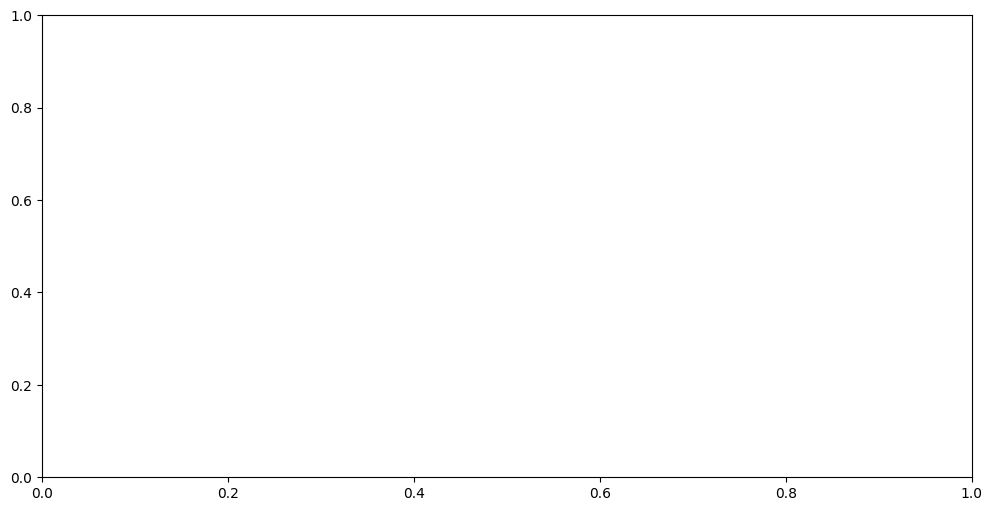

In [89]:
epochs_range = range(0, num_epochs, 1)
# Plotting PDE Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, test_loss_pde_list, label='Test PDE Loss', alpha=.5)
plt.plot(epochs_range, loss_pde_list, label='PDE Loss')
plt.title('PDE Loss Over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Periodic Boundary Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, test_loss_per_bc_list, label='Test Periodic Boundary Loss', alpha=.5)
plt.plot(epochs_range, loss_per_bc_list, label='Periodic Boundary Loss')
plt.title('Boundaries Loss Over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Boundaries Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, test_loss_bot_vel_bc_list, label='Test Boundaries Loss', alpha=.5)
plt.plot(epochs_range, loss_bot_vel_bc_list, label='Boundaries Loss')
plt.title('Boundaries Loss Over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Data Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, test_loss_data_list, label='Test Data Loss', alpha=.5)
plt.plot(epochs_range, loss_data_list, label='Data Loss')
plt.title('Data Loss Over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Total Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, test_total_loss_list, label='Test Total Loss', alpha=.5)
plt.plot(epochs_range, total_loss_list, label='Total Loss')
plt.title('Total Loss Over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#3D Plot with test data

In [ ]:
total_test_data = []
total_test_data_scaled = []
test_data_size=50
#generate test data
test_input_data_function_approximation, test_target_data_function_approximation = generate_data_function_approximation(test_data_size)
test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1 = generate_periodic_boundary_data(test_data_size, x1_values=[0, 2])
test_input_data_pde_loss = generate_data_pde_loss(test_data_size)
test_input_data_vel_bottom = generate_data_bottom_velocity(test_data_size)

#WARNING: the values added here must be the same as in standardized data
#total_test_data.extend(test_input_data_function_approximation)
total_test_data.extend(test_input_data_boundary_conditions_0)
total_test_data.extend(test_input_data_boundary_conditions_1)
#total_test_data.extend(test_input_data_pde_loss)
#total_test_data.extend(test_input_data_vel_bottom)

#normalize data
test_input_data_function_approximation, test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1, test_input_data_pde_loss, test_input_data_vel_bottom = normalize_data(test_input_data_function_approximation, test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1, test_input_data_pde_loss, test_input_data_vel_bottom,test_data_size)


#add standardized data
#WARINING: the values added here must be the same as above
#total_test_data_scaled.extend(test_input_data_function_approximation)
total_test_data_scaled.extend(test_input_data_boundary_conditions_0)
total_test_data_scaled.extend(test_input_data_boundary_conditions_1)
#total_test_data_scaled.extend(test_input_data_pde_loss)
#total_test_data_scaled.extend(test_input_data_vel_bottom)

total_test_data = torch.Tensor(total_test_data)
total_test_data_scaled = torch.Tensor(total_test_data_scaled)
# Convert the list to a PyTorch tensor
output2= model(total_test_data_scaled)

print(output2.shape,(total_test_data_scaled.shape))
print(total_test_data.shape)

In [90]:
x = total_test_data[:,0]
y = total_test_data[:,1]
print(x,y)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]) tensor([-0.5529, -0.8438, -0.0118, -0.4033, -0.1360, -0.0783, -0.2006, -0.7304,
        -0.6765, -0.1711, -0.6381, -0.2806, -0.0231, -0.5234, -0.3644, -0.2466,
        -0.5173, -0.6797, -0.9950, -0.4131, -0.5918, -0.7578, -0.6153, -0.7799,
        -0.5762, -0.4989, -0.5682, -0.4357, -0.2644, -0.5383, -0.6183, -0.7007,
        -0.9916, -0.3457, -0.3340, -0.2020, -0.2462, -0.6735, -0.9947, -0.9333,
        -0.2297, -0.7397, -0.1695, -0.1425, -0.2304, -0.2606, -0.1579, -0.8268,
        -0.2084, -0.8737, -0.5529, -0.8438, -0.0118, -0.4033, -0.1360, 

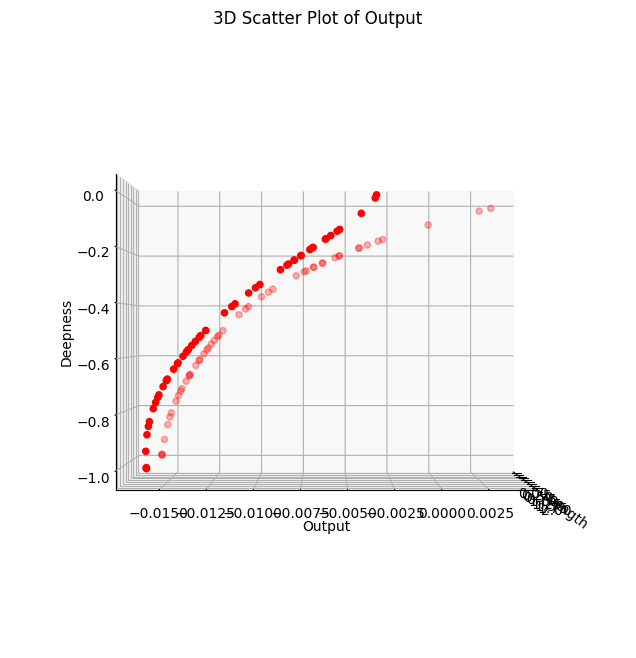

In [91]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming total_test_data[0] and total_test_data[1] are 1D arrays
x = total_test_data[:,0]
y = total_test_data[:,1]
z = output2.detach().numpy()  # Convert the torch Tensor to a NumPy array


# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(x,z, y, c='r', marker='o')

# Set labels
ax.set_xlabel('Length')
ax.set_ylabel('Output')
ax.set_zlabel('Deepness')

# Set title
ax.set_title('3D Scatter Plot of Output')

#ax.view_init(elev=90, azim=90)  # better angle to analyze z=0
ax.view_init(elev=0, azim=0)   #better angle to analyze periodic boundaries
# Show the plot
plt.show()


#Analytical Φ(z=0) vs Predicted Φ(z=0)

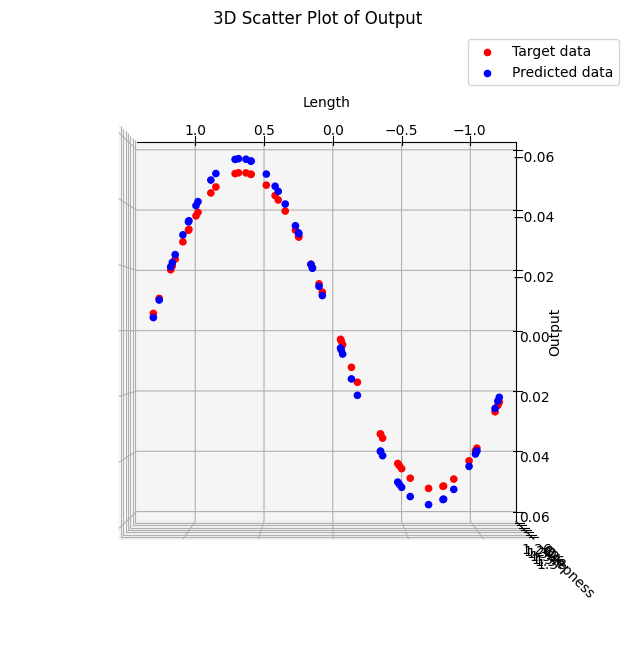

In [92]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming total_test_data[0] and total_test_data[1] are 1D arrays
x = test_input_data_function_approximation[:,0]
y = test_input_data_function_approximation[:,1]
zt = test_target_data_function_approximation  # Convert the torch Tensor to a NumPy array
zp = model(torch.Tensor(test_input_data_function_approximation))
zp= zp.detach().numpy()

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(x,zt, y, c='r', marker='o', label='Target data')
ax.scatter(x,zp, y, c='b', marker='o', label='Predicted data')

ax.legend()
# Set labels
ax.set_xlabel('Length')
ax.set_ylabel('Output')
ax.set_zlabel('Deepness')

# Set title
ax.set_title('3D Scatter Plot of Output')

ax.view_init(elev=90, azim=90)  # You can adjust the elev and azim values

# Show the plot
plt.show()

In [93]:
def compute_output_grad(input):

    # Forward pass through the model
    output = model(input.requires_grad_())

    # Compute gradients with respect to both x1_tensor and x2_tensor using a single call
    grads = torch.autograd.grad(output, input, grad_outputs=torch.ones_like(output), create_graph=True)[0]

    grad_x1 = grads[:, 0]
    grad_x2 = grads[:, 1]

    return grad_x1, grad_x2

(2, 900)


Text(0.5, 1.0, 'Network function results')

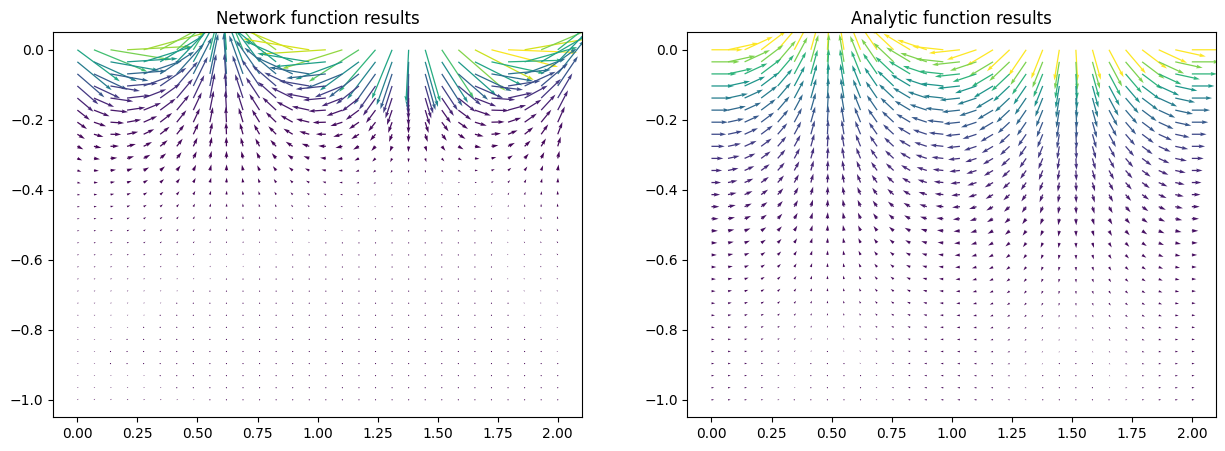

In [94]:
#Todo: Implement with 25 meshgrid better picture but does not work with the compute_output function
x = np.linspace(0,2,30)
y = np.linspace(0,-1,30)
X,Y  = np.meshgrid(x,y)

positions = np.vstack([X.ravel(), Y.ravel()])
print(positions.shape)

# Stack X and Y vertically
data = np.vstack([X.flatten(), Y.flatten()]).T

# Create and fit the scaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Calculate velocity of water for specific x,y direction
u_analytic, v_analytic  = velocity_func(positions.T)
u_network, v_network = compute_output_grad(torch.Tensor(scaled_data))
u_network = u_network.detach().numpy()
v_network = v_network.detach().numpy()


fig , axs = plt.subplots(1,2, figsize = (15,5))
axs[0].quiver(X,Y,u_network, v_network, v_network**2+u_network**2 )
axs[1].quiver(X,Y,u_analytic,v_analytic,(v_analytic**2+u_analytic**2))
axs[1].set_title('Analytic function results')
axs[0].set_title('Network function results')

#total_test_data = torch.Tensor(total_test_data)
#total_test_data_scaled = torch.Tensor(total_test_data_scaled)
# Convert the list to a PyTorch tensor

(2, 900)


Text(0.5, 1.0, 'Network function results w. PDE')

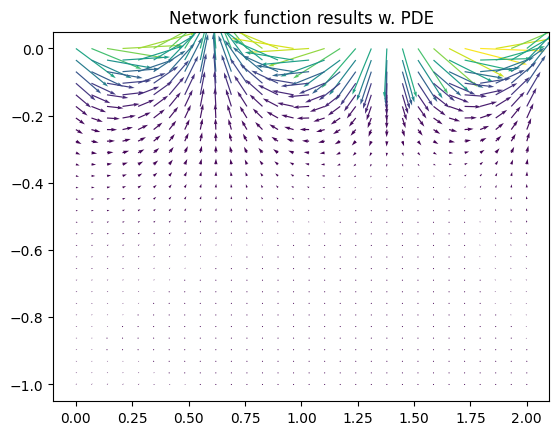

In [95]:
#Todo: Implement with 25 meshgrid better picture but does not work with the compute_output function
x = np.linspace(0,2,30)
y = np.linspace(0,-1,30)
X,Y  = np.meshgrid(x,y)

positions = np.vstack([X.ravel(), Y.ravel()])
print(positions.shape)

# Stack X and Y vertically
data = np.vstack([X.flatten(), Y.flatten()]).T

# Create and fit the scaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Calculate velocity of water for specific x,y direction
u_analytic, v_analytic  = velocity_func(positions.T)
u_network, v_network = compute_output_grad(torch.Tensor(scaled_data))
u_network = u_network.detach().numpy()
v_network = v_network.detach().numpy()


#fig , axs = plt.subplots(1,2, figsize = (15,5))
#axs[0].quiver(X,Y,u_network, v_network, v_network**2+u_network**2 )
#axs[1].quiver(X,Y,u_analytic,v_analytic,(v_analytic**2+u_analytic**2))
#axs[1].set_title('Analytic function results')
#axs[0].set_title('Network function results')

plt.quiver(X,Y,u_network, v_network, v_network**2+u_network**2 )
plt.title('Network function results w. PDE')

#total_test_data = torch.Tensor(total_test_data)
#total_test_data_scaled = torch.Tensor(total_test_data_scaled)
# Convert the list to a PyTorch tensor

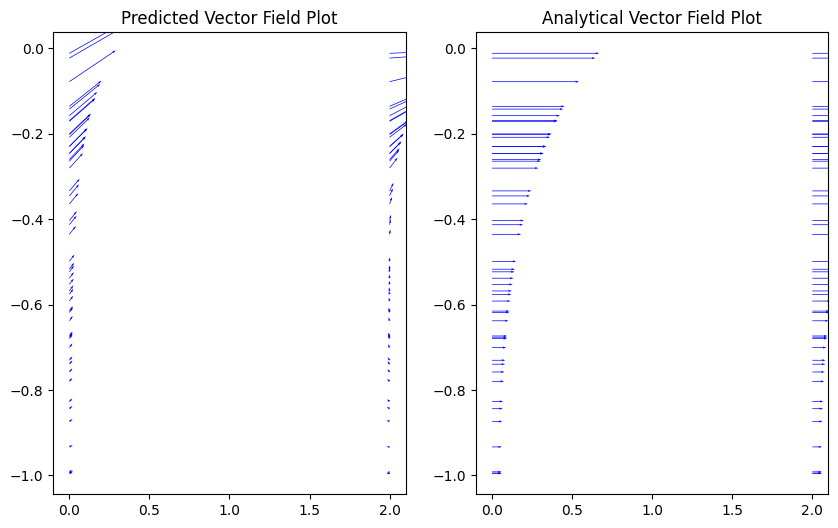

In [96]:
def plotVelocity(total_test_data,total_test_data_scaled,prediction, ax):

  if prediction:
    u_values, v_values = compute_output_grad(total_test_data_scaled)
  else:
    u_values, v_values = velocity_func(total_test_data.detach().numpy())

  # Plotting
  x_values = total_test_data[:, 0].detach().numpy()
  y_values = total_test_data[:, 1].detach().numpy()
  if prediction:
    u_values = u_values.detach().numpy()
    v_values = v_values.detach().numpy()



  # Plotting the vector field
  ax.quiver(x_values, y_values, u_values, v_values, scale=.5, angles = 'xy',color='blue', width=0.002)
  if prediction:
    ax.set_title('Predicted Vector Field Plot')
  else:
    ax.set_title('Analytical Vector Field Plot')


  return torch.from_numpy(u_values).view(-1,1), torch.from_numpy(v_values).view(-1,1)

fig, axs = plt.subplots(1,2,figsize=(10,6 ))
u_predicted,v_predicted=plotVelocity(total_test_data,total_test_data_scaled,True,ax = axs[0])
u_analytical,v_analytical= plotVelocity(total_test_data,total_test_data_scaled,False,ax = axs[1])

#print(u_analytical)
#print(u_predicted)
#print(total_test_data)

In [97]:
criterion=torch.nn.SmoothL1Loss()

u_loss=criterion(torch.Tensor(u_analytical),u_predicted)

v_loss=criterion(torch.Tensor(v_analytical), v_predicted)

print(f'Relative error u velocity: {abs(u_loss)/abs(torch.mean(torch.Tensor(u_analytical)))*100}%')
print(f'Relative error v velocity: {abs(v_loss)/abs(torch.mean(torch.Tensor(v_analytical)))*100}%')

Relative error u velocity: 1.182395577430725%
Relative error v velocity: 831067.5625%


#No PDE

##Parameters and data

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Define parameters
num_epochs = 5000
learning_rate = 10**-4
momentum = 0.9
#alpha = 1.0  # Weight for data loss
#beta = 1.0   # Weight for periodic boundary condition loss
#epsilon = 1.0 # Weight for bottom velocity boundary condition loss
#gamma = 1.0  # Weight for PDE loss


# Create the model and optimizer
model = FNN()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

training_data_size=20
test_data_size=5

# Generate training data for each component of the PINN loss
input_data_function_approximation, target_data_function_approximation = generate_data_function_approximation(training_data_size)
input_data_boundary_conditions_0, input_data_boundary_conditions_1 = generate_periodic_boundary_data(training_data_size, x1_values=[0, 2])
input_data_pde_loss = generate_data_pde_loss(training_data_size)
input_data_vel_bottom = generate_data_bottom_velocity(training_data_size)



#normalize data
input_data_function_approximation, input_data_boundary_conditions_0,input_data_boundary_conditions_1,input_data_pde_loss, input_data_vel_bottom = normalize_data(input_data_function_approximation, input_data_boundary_conditions_0,input_data_boundary_conditions_1,input_data_pde_loss, input_data_vel_bottom,training_data_size)

# Change 1: Create a SoftAdapt object (with your desired variant)
softadapt_object = LossWeightedSoftAdapt(beta=0.1)

# Change 2: Define how often SoftAdapt calculate weights for the loss components
epochs_to_make_updates = 5

# Change 3: Initialize lists to keep track of loss values over the epochs we defined above
values_of_component_1 = []
values_of_component_2 = []
#values_of_component_3 = []
values_of_component_4 = []
# Initializing adaptive weights to all ones.
adapt_weights = torch.tensor([1,1,1])

##Training loop

In [54]:
# Lists to store training losses for plotting
loss_pde_list = []
#loss_bc_list = []
loss_data_list = []
total_loss_list_no_PDE = []
loss_per_bc_list=[]
loss_bot_vel_bc_list=[]

# Lists to store test losses for plotting
test_loss_pde_list = []
#test_loss_bc_list = []
test_loss_data_list = []
test_total_loss_list_no_PDE = []
test_loss_per_bc_list=[]
test_loss_bot_vel_bc_list=[]

# Training loop
for epoch in range(num_epochs):


    # Forward pass for each component
    predicted_data_function_approximation = model(torch.from_numpy(input_data_function_approximation).float())

    # Compute losses
    loss_function_approximation = data_loss(predicted_data_function_approximation, torch.Tensor(target_data_function_approximation).float())

    boundary_conditions = {
      'bc1': compute_bc1(model, input_data_vel_bottom[:,0], input_data_vel_bottom[:,1]),   # at x2=-1 the grad perpendicular to the bottom is null
      'bc2_0': compute_bc2(model,torch.Tensor( input_data_boundary_conditions_0)),  # at x1 = 0
      'bc2_1': compute_bc2(model,torch.Tensor( input_data_boundary_conditions_1)),  # at x1 = 2
    }

    #loss_boundary_conditions = beta* boundary_condition_loss(boundary_conditions,predicted_data_function_approximation)

    loss_periodic_boundary = periodic_boundary_loss(boundary_conditions)

    #loss_pde_loss= pde_loss(model,torch.tensor(input_data_pde_loss, requires_grad = True, dtype=torch.float))

    loss_vel_bottom_boundary = bottom_velocity_boundary_loss(boundary_conditions,predicted_data_function_approximation)

    # Keeping track of each loss component
    values_of_component_1.append(loss_function_approximation)
    values_of_component_2.append( loss_periodic_boundary )
    #values_of_component_3.append(loss_pde_loss)
    values_of_component_4.append(loss_vel_bottom_boundary)

    # Change 4: Make sure `epochs_to_make_change` have passed before calling SoftAdapt.
    if epoch % epochs_to_make_updates == 0 and epoch != 0:
        adapt_weights = softadapt_object.get_component_weights(torch.tensor(values_of_component_1),
                                                               torch.tensor(values_of_component_2),
                                                               torch.tensor(values_of_component_4),
                                                               verbose=False,
                                                               )
        # Resetting the lists to start fresh (this part is optional)
        values_of_component_1 = []
        values_of_component_2 = []
        #values_of_component_3 = []
        values_of_component_4 = []



    # Total loss
    #total_loss = loss_function_approximation + loss_boundary_conditions + loss_pde_loss

    #total_loss = loss_function_approximation + loss_periodic_boundary + loss_vel_bottom_boundary + loss_pde_loss

    total_loss = adapt_weights[0] * loss_function_approximation + adapt_weights[1]*loss_periodic_boundary + adapt_weights[2]*loss_vel_bottom_boundary
    # Backward pass and optimization
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()



    # Append losses to the lists
    loss_pde_list.append(loss_pde_loss.item())
    #loss_bc_list.append(loss_boundary_conditions.item())
    loss_per_bc_list.append(loss_periodic_boundary.item())
    loss_bot_vel_bc_list.append(loss_vel_bottom_boundary.item())
    loss_data_list.append(loss_function_approximation.item())
    total_loss_list_no_PDE.append(total_loss.item())

    # Generate test data for each component of the PINN loss
    test_input_data_function_approximation, test_target_data_function_approximation = generate_data_function_approximation(test_data_size)
    test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1 = generate_periodic_boundary_data(test_data_size, x1_values=[0, 2])
    test_input_data_pde_loss = generate_data_pde_loss(test_data_size)
    test_input_data_vel_bottom = generate_data_bottom_velocity(test_data_size)

    #normalize data
    test_input_data_function_approximation, test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1,test_input_data_pde_loss, test_input_data_vel_bottom = normalize_data(test_input_data_function_approximation, test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1,test_input_data_pde_loss, test_input_data_vel_bottom,test_data_size)
    # Test loop
    # Forward pass for each component
    test_predicted_data_function_approximation = model(torch.Tensor(test_input_data_function_approximation))

    # Compute test losses
    test_loss_function_approximation = data_loss(test_predicted_data_function_approximation, torch.Tensor(test_target_data_function_approximation))

    test_boundary_conditions = {
        'bc1': compute_bc1(model, test_input_data_vel_bottom[:, 0], test_input_data_vel_bottom[:, 1]),
        'bc2_0': compute_bc2(model, torch.Tensor(test_input_data_boundary_conditions_0)),
        'bc2_1': compute_bc2(model, torch.Tensor(test_input_data_boundary_conditions_1)),
    }

    #test_loss_boundary_conditions = beta*boundary_condition_loss(test_boundary_conditions, test_predicted_data_function_approximation)

    test_loss_periodic_boundary = periodic_boundary_loss(test_boundary_conditions)

    test_loss_vel_bottom_boundary = bottom_velocity_boundary_loss(test_boundary_conditions,test_predicted_data_function_approximation)


    #test_loss_pde_loss = pde_loss(model, torch.tensor(test_input_data_pde_loss, requires_grad = True, dtype=torch.float))

    # Total test loss
    #test_total_loss = test_loss_function_approximation + test_loss_boundary_conditions + test_loss_pde_loss
    test_total_loss_no_PDE = test_loss_function_approximation + test_loss_periodic_boundary + test_loss_vel_bottom_boundary

    # Append test losses to the lists
    #test_loss_pde_list.append(test_loss_pde_loss.item())
    #test_loss_bc_list.append(test_loss_boundary_conditions.item())
    test_loss_bot_vel_bc_list.append(test_loss_vel_bottom_boundary.item())
    test_loss_per_bc_list.append(test_loss_periodic_boundary.item())
    test_loss_data_list.append(test_loss_function_approximation.item())
    test_total_loss_list_no_PDE.append(test_total_loss_no_PDE.item())

    # Print loss for monitoring
    if epoch % 100 == 0:
        #print(f'Epoch {epoch}/{num_epochs},train PDE Loss: {loss_pde_loss}')
        #print(f'Epoch {epoch}/{num_epochs},train Boundaries Loss: {loss_boundary_conditions}')
        print(f'Epoch {epoch}/{num_epochs},train Periodic Boundary Loss: {loss_periodic_boundary}')
        print(f'Epoch {epoch}/{num_epochs},train Bottom Velocity Boundary Loss: {loss_vel_bottom_boundary}')
        print(f'Epoch {epoch}/{num_epochs},train Data Loss: {loss_function_approximation}')
        print(f'Epoch {epoch}/{num_epochs},train Total Loss: {total_loss.item()}')
        print("------------------------------------------------------------")
        #print(f'Epoch {epoch}/{num_epochs},test PDE Loss: {test_loss_pde_loss}')
        #print(f'Epoch {epoch}/{num_epochs},test Boundaries Loss: {test_loss_boundary_conditions}')
        print(f'Epoch {epoch}/{num_epochs},test Periodic Boundary Loss: {test_loss_periodic_boundary}')
        print(f'Epoch {epoch}/{num_epochs},test Bottom Velocity Boundary Loss: {test_loss_vel_bottom_boundary}')
        print(f'Epoch {epoch}/{num_epochs},test Data Loss: {test_loss_function_approximation}')
        print(f'Epoch {epoch}/{num_epochs},test Total Loss: {test_total_loss.item()}')
        print("#############################################################")
        print("#############################################################")
# After training, you can use the trained model for predictions or further analysis


Epoch 0/5000,train Periodic Boundary Loss: 0.0004055118770338595
Epoch 0/5000,train Bottom Velocity Boundary Loss: 0.001097524305805564
Epoch 0/5000,train Data Loss: 0.003221837803721428
Epoch 0/5000,train Total Loss: 0.004724874161183834
------------------------------------------------------------
Epoch 0/5000,test Periodic Boundary Loss: 4.021915447083302e-05
Epoch 0/5000,test Bottom Velocity Boundary Loss: 0.0011799739440903068
Epoch 0/5000,test Data Loss: 0.0020288776140660048
Epoch 0/5000,test Total Loss: 2.8411870516720228e-05
#############################################################
#############################################################
Epoch 100/5000,train Periodic Boundary Loss: 9.22636390896514e-05
Epoch 100/5000,train Bottom Velocity Boundary Loss: 1.8067685232381336e-06
Epoch 100/5000,train Data Loss: 0.0005626204656437039
Epoch 100/5000,train Total Loss: 0.0004111853585566059
------------------------------------------------------------
Epoch 100/5000,test Period

(2, 900)


Text(0.5, 1.0, 'Network function results w.o. PDE')

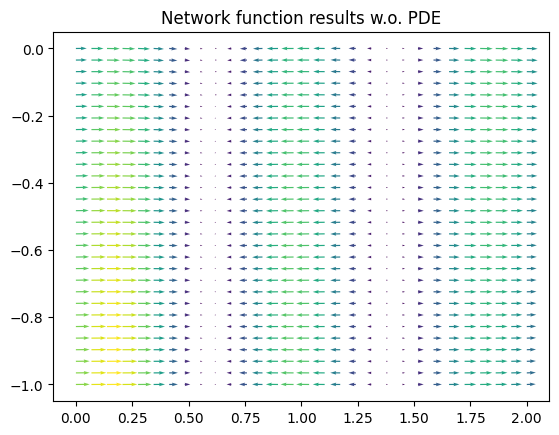

In [63]:
#Todo: Implement with 25 meshgrid better picture but does not work with the compute_output function
x = np.linspace(0,2,30)
y = np.linspace(0,-1,30)
X,Y  = np.meshgrid(x,y)

positions = np.vstack([X.ravel(), Y.ravel()])
print(positions.shape)

# Stack X and Y vertically
data = np.vstack([X.flatten(), Y.flatten()]).T

# Create and fit the scaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Calculate velocity of water for specific x,y direction
u_analytic, v_analytic  = velocity_func(positions.T)
u_network, v_network = compute_output_grad(torch.Tensor(scaled_data))
u_network = u_network.detach().numpy()
v_network = v_network.detach().numpy()


#fig , axs = plt.subplots(1,2, figsize = (15,5)) #1,2 for both
#axs[0].quiver(X,Y,u_network, v_network, v_network**2+u_network**2 )
plt.quiver(X,Y,u_network, v_network, v_network**2+u_network**2 )
#axs[1].quiver(X,Y,u_analytic,v_analytic,(v_analytic**2+u_analytic**2))
#axs[1].set_title('Analytic function results')
#axs[0].set_title('Network function results')
plt.title('Network function results w.o. PDE')

#total_test_data = torch.Tensor(total_test_data)
#total_test_data_scaled = torch.Tensor(total_test_data_scaled)
# Convert the list to a PyTorch tensor